In [1]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 2  # the generated image resolution
    train_batch_size = 256
    eval_batch_size = 256  # how many images to sample during evaluation
    num_epochs = 500
    patience = 200  # early stopping patience
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    output_dir = "test-model-1"  # the model name locally and on the HF Hub



config = TrainingConfig()

# Construct the dataset

In [87]:
import torch
from torch.utils.data import Dataset, ConcatDataset
import numpy as np
from tqdm import tqdm

class GaussianDataset(Dataset):
    def __init__(self, num_samples, input_dim, cov, samples_per_obs, obs_trans = None):
        self.num_samples = num_samples
        self.input_dim = input_dim
        self.cov = cov

        self.o = []
        self.a = []
        # Generate input data (o)
        for _ in range(num_samples):
            obs = np.random.normal(size=(input_dim))
            if obs_trans is not None:
                obs = obs_trans(obs)

            for _ in range(samples_per_obs):

                # Generate output data (a) using the Gaussian distribution
                act = np.random.multivariate_normal(mean=obs, cov=self.cov)

                self.o.append(obs)
                self.a.append(act)

        print(f"Generated {len(self.o)} samples")


    def __len__(self):
        return len(self.o)
    
    def get_observations(self):
        return self.o

    def __getitem__(self, idx):
        o = torch.tensor(self.o[idx], dtype=torch.float32)
        a = torch.tensor(self.a[idx], dtype=torch.float32)
        return o, a
    
def generate_random_cov_matrix(dim, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Generate a random matrix
    A = np.random.normal(size=(dim, dim))

    # Make the matrix symmetric
    A = np.triu(A) + np.triu(A, 1).T

    # Make the matrix positive semi-definite
    cov_matrix = np.dot(A, A.T)

    return cov_matrix

def get_sim_trans(seed_A=None, seed_B=None, mag=0.5):
    if seed_A is None:
        A = np.random.uniform(low=-mag, high=mag, size=(config.image_size, config.image_size))
    if seed_B is None:
        B = np.random.uniform(low=-mag, high=mag, size=(config.image_size, 1))

    def trans_func(x):
        return x + (np.dot(A, x[:, np.newaxis]) + B).flatten()
    
    return trans_func

In [88]:
# Set parameters

action_dim = 2
cov = generate_random_cov_matrix(action_dim)
sim_cov = cov + generate_random_cov_matrix(action_dim) * 0.01
samples_per_obs = 1
real_samples = int(1000 / samples_per_obs)
sim_saples = int(100000 / samples_per_obs)

sim_trans_func = get_sim_trans()

# example of how to use the transformation function
print(sim_trans_func(np.array([1, 2])))

# Create dataset
real_dataset = GaussianDataset(real_samples, action_dim, cov, samples_per_obs)

sim_dataset = GaussianDataset(sim_saples, action_dim, sim_cov, samples_per_obs, obs_trans=sim_trans_func)

val_dataset = GaussianDataset(100, action_dim, cov, samples_per_obs)

test_dataset = GaussianDataset(1000, action_dim, cov, samples_per_obs)

# Concatenate datasets
dataset = ConcatDataset([real_dataset, sim_dataset])

# Create data loader
batch_size = config.train_batch_size
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for step, batch in enumerate(data_loader):
    o, a = batch
    print(o.shape, a.shape)
    break

# Construct validation dataset


[1.23682159 1.3881602 ]
Generated 1000 samples
Generated 100000 samples
Generated 100 samples
Generated 1000 samples
torch.Size([256, 2]) torch.Size([256, 2])


## Plots the dataset

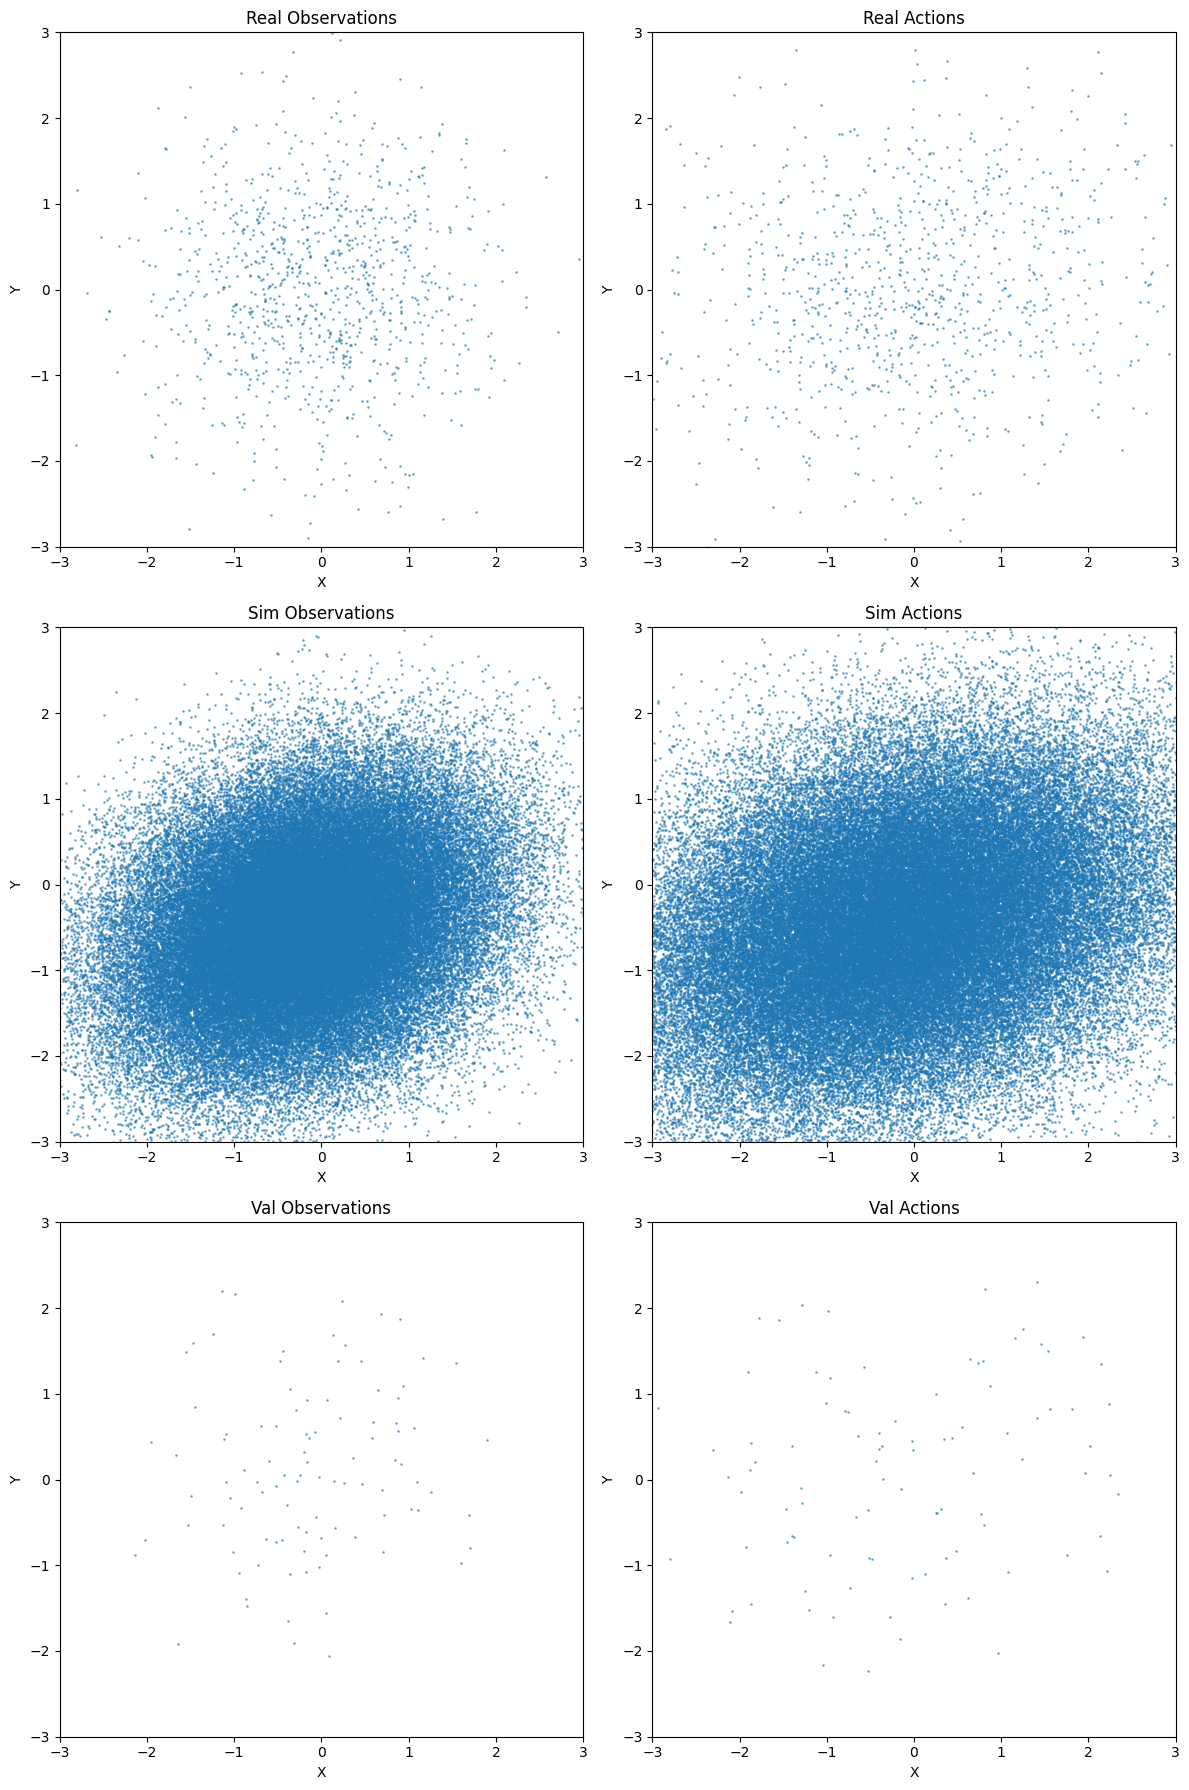

In [89]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

real_obs = np.array([o for o, _ in real_dataset])
real_act = np.array([a for _, a in real_dataset])

sim_obs = np.array([o for o, _ in sim_dataset])
sim_act = np.array([a for _, a in sim_dataset])

val_obs = np.array([o for o, _ in val_dataset])
val_act = np.array([a for _, a in val_dataset])

# Create a figure with 3 rows and 2 columns
plt.figure(figsize=(12, 18))

# Real dataset
plt.subplot(3, 2, 1)
plt.scatter(real_obs[:, 0], real_obs[:, 1], s=1, alpha=0.5)
plt.title("Real Observations")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.subplot(3, 2, 2)
plt.scatter(real_act[:, 0], real_act[:, 1], s=1, alpha=0.5)
plt.title("Real Actions")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# Sim dataset
plt.subplot(3, 2, 3)
plt.scatter(sim_obs[:, 0], sim_obs[:, 1], s=1, alpha=0.5)
plt.title("Sim Observations")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.subplot(3, 2, 4)
plt.scatter(sim_act[:, 0], sim_act[:, 1], s=1, alpha=0.5)
plt.title("Sim Actions")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# Val dataset
plt.subplot(3, 2, 5)
plt.scatter(val_obs[:, 0], val_obs[:, 1], s=1, alpha=0.5)
plt.title("Val Observations")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.subplot(3, 2, 6)
plt.scatter(val_act[:, 0], val_act[:, 1], s=1, alpha=0.5)
plt.title("Val Actions")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.tight_layout()
plt.show()

# Construct the Neural Network

In [90]:
import torch.nn as nn
from diffusers import UNet2DModel

import torch
import torch.nn as nn
import torch.nn.functional as F


class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_period=10000):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.max_period = max_period

    def forward(self, t):
        half_dim = self.embedding_dim // 2
        emb = torch.cat([torch.sin(t * (10000 ** (torch.arange(half_dim, device=t.device) / half_dim))), 
                        torch.cos(t * (10000 ** (torch.arange(half_dim, device=t.device) / half_dim)))], dim=-1)
        return emb

class ClassConditionedMLP(nn.Module):
    def __init__(self, action_dim=2, class_emb_size=2, hidden_dim=64, num_layers=3, time_emb_dim=128):
        super().__init__()
        
        self.time_embedding = TimeEmbedding(time_emb_dim)
        
        # Input dimension: (action_dim + class_emb_size) + time_emb_dim
        input_dim = action_dim * 1 + class_emb_size * 1 + time_emb_dim
        output_dim = action_dim * 1  # Matches the output shape of the UNet
        
        # Define a simple MLP architecture
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, obs, act, t):
        # Flatten input dimensions and prepare input for MLP
        act = torch.tensor(act).unsqueeze(1).unsqueeze(-1)  # Convert to tensor and shape (bs, 1, 2, 1)
        bs, ch, w, h = act.shape
        act_flat = act.view(bs, -1)  # Flatten to (bs, action_dim)
        
        class_cond = torch.tensor(obs)  # Convert to tensor (bs, class_emb_size)
        
        # Encode timestep
        t = torch.tensor(t).unsqueeze(-1)  # Convert timestep to tensor (bs, 1)

        t_emb = self.time_embedding(t)  # Encode timestep
        
        # Concatenate action, class conditioning, and encoded timestep
        mlp_input = torch.cat([act_flat, class_cond, t_emb], dim=1)  # Shape: (bs, input_dim)
        
        # Pass through MLP
        output = self.mlp(mlp_input)  # Shape: (bs, output_dim)
        
        # Reshape to match UNet's output: (bs, 1, action_dim, 1)
        return output.view(bs, 1, w, h)


class ClassConditionedUnet(nn.Module):
    def __init__(self, action_dim=2, class_emb_size=2):
        super().__init__()

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size=(action_dim, 1),  # the target image resolution
            in_channels=1 + class_emb_size,  # Additional input channels for class cond.
            out_channels=1,  # the number of output channels
            block_out_channels=(32,),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
            ),
            up_block_types=(
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, obs, act, t):
        act = torch.Tensor(act).unsqueeze(1).unsqueeze(-1)  # Convert to tensor and move to device
        # Shape of x:
        bs, ch, w, h = act.shape

        # class conditioning in right shape to add as additional input channels
        class_cond = torch.Tensor(obs) # Convert to tensor and move to device
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # x is shape (bs, 1, 2, 1) and class_cond is now (bs, 2, 2, 1)

        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((act, class_cond), 1)  # (bs, 3, 2, 1)

        # Feed this to the UNet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  # (bs, 1, 2, 1)

# Initialize the MLP with the desired action dimension
model = ClassConditionedMLP(action_dim=action_dim)

# Print the MLP architecture
print(model)

/home/rbosworth/DiffusionCoTrainingToy/diffusion_toy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ClassConditionedMLP(
  (time_embedding): TimeEmbedding()
  (mlp): Sequential(
    (0): Linear(in_features=132, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [91]:
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler
import torch.nn.functional as F

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(data_loader) * config.num_epochs),
)

# Train the policy

In [95]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
import wandb
import torch
import torch.nn.functional as F


wandb.init(project="diffusion-toy", entity="rohanb27-csail")


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, val_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="wandb",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, val_dataloader, lr_scheduler
    )

    global_step = 0

    epochs_since_improvement = 0

    prev_val_loss = float("inf")

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            # Unpack the batch
            obs, act = batch
            # Concatenate observation and action
            inputs = torch.cat((obs, act), dim=1)
            bs = inputs.shape[0]

            # Sample noise to add to the actions
            noise = torch.randn(act.shape, device=act.device)

            # Sample a random timestep for each action
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=act.device,
                dtype=torch.int64
            )

            # Add noise to the clean actions according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_actions = noise_scheduler.add_noise(act, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(obs, noisy_actions, timesteps).squeeze()

                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            
            
            global_step += 1

        # Validate after each epoch
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                obs, act = batch
                inputs = torch.cat((obs, act), dim=1)
                bs = inputs.shape[0]

                noise = torch.randn(act.shape, device=act.device)
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bs,), device=act.device,
                    dtype=torch.int64
                )
                noisy_actions = noise_scheduler.add_noise(act, noise, timesteps)
                noise_pred = model(obs, noisy_actions, timesteps).squeeze()
                loss = F.mse_loss(noise_pred, noise)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)

        logs = {"train-loss": loss.detach().item(), "val-loss": val_loss, "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if val_loss < prev_val_loss:
            prev_val_loss = val_loss
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        if epochs_since_improvement >= config.patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Save the model after each epoch
        if accelerator.is_main_process and epoch % config.save_model_epochs == 0:
            ...
            #pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model.model), scheduler=noise_scheduler)
            #pipeline.save_pretrained(config.output_dir)

        model.train()

In [96]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, data_loader, val_data_loader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


Epoch 0:   0%|          | 0/395 [00:00<?, ?it/s]/tmp/ipykernel_144708/2719386989.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  act = torch.tensor(act).unsqueeze(1).unsqueeze(-1)  # Convert to tensor and shape (bs, 1, 2, 1)
/tmp/ipykernel_144708/2719386989.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_cond = torch.tensor(obs)  # Convert to tensor (bs, class_emb_size)
/tmp/ipykernel_144708/2719386989.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).unsqueeze(-1)  # Convert timestep to tensor (bs, 

KeyboardInterrupt: 

In [97]:
torch.save(model, "saved_models/MLP-model.pth")

In [ ]:
# @markdown Sampling some different digits:
import torch
from diffusers import DDPMScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
model = torch.load("saved_models/MLP-model.pth").to(device)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)

# TBD: compute function for optimal solution
alphas_cum_prod = noise_scheduler.alphas_cumprod

model.eval()

# Prepare random x to start from, plus some desired labels y
# obs, act_desired = sim_dataset[0:2]

obs = torch.tensor([[-2.8121,  1.9047],
        [-2.8121,  1.9047], [-2.8121,  1.9047]])
act_desired = torch.tensor([[-2.8110,  1.8979],
        [-2.6461,  1.8752]])

obs = torch.tensor([[2.5,  2.5],
        [-2.5,  2.5], [2.5,  -2.5]])
act_desired = torch.tensor([[-2.8110,  1.8979],
        [-2.6461,  1.8752]])

act = torch.randn(3, 2)
#act = torch.tensor([[-2.8121,  1.9047],
#        [-2.8121,  1.9047]])
act = act.to(device)
obs = obs.to(device)

        
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(obs, act, [t for _ in range(3)]).squeeze() # Again, note that we pass in our labels y

    # Update sample with step
    act = noise_scheduler.step(residual, t, act).prev_sample



# Show the results
#fig, ax = plt.subplots(1, 1, figsize=(12, 12))
#ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")

/tmp/ipykernel_144708/4072390807.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_models/MLP-model.pth").to(device)
/tmp/ipykernel_144708/271938

In [103]:
print(alphas_cum_prod.size())

torch.Size([1000])
